#### 해당 방식 코드 차이는 샘플링 방식과 Test 성능 측정에서 존재.

샘플링 : 정해진 개수만큼 같은 클래스 및 다른 클래스를 번갈아가며 샘플링
성능 측정 : Train과 동일하게 번갈아가며 샘플링 -> 유사도가 0.5 이상이라면? 임시 라벨을 1로 부여하고 실제 라벨과 비교

In [1]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import random
import shutil
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F

### 데이터 전처리(로드 및 데이터셋 분리)

#### 데이터셋 밸런싱 및 로드

In [2]:
NORMAL_PATH = '/home/cti/byeongyeol/siamese_network/dataset/normal_abnormal/resize_normal'
ABNORMAL_PATH = '/home/cti/byeongyeol/siamese_network/dataset/normal_abnormal/abnormal_kisa'
BALANCE_ABNORMAL_PATH = '/home/cti/byeongyeol/siamese_network/dataset/normal_abnormal/abnormal_kisa'

FRE_NORMAL_PATH = '/home/cti/byeongyeol/siamese_network/dataset/frequency/img/NORMAL'

FRE_BALANCE_ABNORMAL_PATH = '/home/cti/byeongyeol/siamese_network/dataset/frequency/img/MALWARE'

#  Data Unbalance
# if not os.path.isdir(BALANCE_ABNORMAL_PATH):
#     os.mkdir(BALANCE_ABNORMAL_PATH)

#     try:
#         # 데이터 언밸런싱 해결
#         abnormal_data = os.listdir(ABNORMAL_PATH)
#         abnormal_data_len = len(abnormal_data)
#         random_sample_idx = np.random.choice(range(abnormal_data_len), size=10000, replace=False)
    
#         for i in random_sample_idx:
#             file_name = abnormal_data[i]
#             shutil.copyfile(f"{ABNORMAL_PATH}/{file_name}", f"{BALANCE_ABNORMAL_PATH}/{file_name}")

#         balance_abnormal_data = os.listdir(BALANCE_ABNORMAL_PATH)
#         print(f"[+] Data Balancing Finish! \n[+] Balance Abnormal Data : {len(balance_abnormal_data)}")

#     except Exception as e:
#         print(f"[-] Error resolving data unbalancing : {e}")

In [3]:
def data_load(normal_path, abnormal_path, fre_normal_path, fre_abnormal_path):
    normal_data = []
    abnormal_data = []
    fre_normal_data = []
    fre_abnormal_data = []
    
    # normal data
    for nl in os.listdir(normal_path):
        normal_sample_path = os.path.join(normal_path, nl)
        normal_data.append(normal_sample_path)

    # abnormal data
    for anl in os.listdir(abnormal_path):
        abnormal_sample_path = os.path.join(abnormal_path, anl)
        abnormal_data.append(abnormal_sample_path)

    # Frequence Normal Data
    for fnl in os.listdir(fre_normal_path):
        fre_normal_sample_path = os.path.join(fre_normal_path, fnl)
        fre_normal_data.append(fre_normal_sample_path)

    # Frequence Abnormal Data
    for fanl in os.listdir(fre_abnormal_path):
        fre_abnormal_sample_path = os.path.join(fre_abnormal_path, fanl)
        fre_abnormal_data.append(fre_abnormal_sample_path)    

    print(f"[+] Normal Data : {len(normal_data)} \n[+] Abnormal Data : {len(abnormal_data)}\n[+] Frequence Normal Data : {len(fre_normal_data)}\n[+] Frequence Abnormal Data : {len(fre_abnormal_data)}")

    
    return normal_data, abnormal_data, fre_normal_data, fre_abnormal_data

In [4]:
normal_data, abnormal_data, fre_normal_data, fre_abnormal_data = data_load(NORMAL_PATH, BALANCE_ABNORMAL_PATH, FRE_NORMAL_PATH, FRE_BALANCE_ABNORMAL_PATH)

[+] Normal Data : 10000 
[+] Abnormal Data : 10000
[+] Frequence Normal Data : 10000
[+] Frequence Abnormal Data : 10000


#### 데이터셋 분리

In [5]:
def split_data(normal_files, abnormal_files, test_size = 0.2):
    normal_train, normal_test, abnormal_train, abnormal_test = train_test_split(normal_files, abnormal_files, test_size = test_size, random_state = 42)
    print(f"[+] Normal Train : {len(normal_train)}\n[+] Normal_test : {len(normal_test)}\n[+] Abnormal_train : {len(abnormal_train)}\n[+] Abnormal_test : {len(abnormal_test)}")
    return normal_train, normal_test, abnormal_train, abnormal_test

normal_train, normal_test, abnormal_train, abnormal_test = split_data(normal_data, abnormal_data)

[+] Normal Train : 8000
[+] Normal_test : 2000
[+] Abnormal_train : 8000
[+] Abnormal_test : 2000


In [6]:
fre_normal_train = []
fre_normal_test = []
fre_abnormal_train = []
fre_abnormal_test = []



def fre_split_data(target_path, target_list, src_data):
    for i in src_data:
        file_name = os.path.basename(i)
        sample_path = os.path.join(target_path, file_name)
        if not os.path.isfile(sample_path):
            print(f"[+] {sample_path} 파일이 존재하지 않음")
            break
        else:
            target_list.append(sample_path)
    return target_list

fre_normal_train = fre_split_data(FRE_NORMAL_PATH, fre_normal_train, normal_train)
fre_normal_test = fre_split_data(FRE_NORMAL_PATH, fre_normal_test, normal_test)
fre_abnormal_train = fre_split_data(FRE_BALANCE_ABNORMAL_PATH, fre_abnormal_train, abnormal_train)
fre_abnormal_test = fre_split_data(FRE_BALANCE_ABNORMAL_PATH, fre_abnormal_test, abnormal_test)

print(f"[+] Frequence Normal Train : {len(fre_normal_train)}\n[+] Frequence Normal_test : {len(fre_normal_test)}\n[+] Frequence Abnormal_train : {len(fre_abnormal_train)}\n[+] Frequence Abnormal_test : {len(fre_abnormal_test)}")

[+] Frequence Normal Train : 8000
[+] Frequence Normal_test : 2000
[+] Frequence Abnormal_train : 8000
[+] Frequence Abnormal_test : 2000


#### Pytorch DataLoader에 로드

##### Image 쌍 생성

In [7]:
def generate_image_pair(normal_files, abnormal_files, is_train, data_len):
    same_class_pair = []
    other_class_pair = []

    for i in range(data_len //2):
        # Same Class Sampling(label = 1)
        if len(normal_files) >= 1:
            idx1, idx2 = random.sample(range(len(normal_files)), 2)
            label = 1.0
            if i % 2 == 0:
                same_class_pair.append((normal_files[idx1], normal_files[idx2], label))
            else:
                same_class_pair.append((abnormal_files[idx1], abnormal_files[idx2], label))

        # Other Class Sampling(label = 0)
        if len(abnormal_files) >= 1:
            idx1, idx2 = random.sample(range(len(abnormal_files)), 2)
            label = 0.0
            other_class_pair.append((normal_files[idx1], abnormal_files[idx2], label))

    return same_class_pair, other_class_pair

# 일반 128 * 128 이미지 
train_same_class_pairs, train_other_class_pairs = generate_image_pair(normal_train, abnormal_train, 'true', 30000)
test_same_class_pairs, test_other_class_pairs = generate_image_pair(normal_test, abnormal_test, 'true', 2000)

# Frequence 기반
fre_train_same_class_pairs, fre_train_other_class_pairs = generate_image_pair(fre_normal_train, fre_abnormal_train, 'true', 30000)
fre_test_same_class_pairs, fre_test_other_class_pairs = generate_image_pair(fre_normal_test, fre_abnormal_test, 'true', 2000)

##### Train, Test Data 로더 정의

In [8]:
class SiameseDataset(Dataset):
    def __init__ (self, pairs, transform = None):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)
        
    def __getitem__(self, idx):
        pair = self.pairs[idx]
        # First Image Get
        img1 = Image.open(pair[0])
        # Second Image Get
        img2 = Image.open(pair[1])

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        label = pair[2]
        return img1, img2, torch.tensor(label, dtype = torch.float32)



class SiameseDataset_test(Dataset):
    def __init__(self, normal, abnormal, fre_normal, fre_abnormal, transform = None):
        self.normal = normal
        self.abnormal = abnormal
        self.fre_normal = fre_normal
        self.fre_abnormal = fre_abnormal
        self.transform = transform

    def __len__(self):
        # return 2000
        return min(len(self.normal), len(self.abnormal))
        
    def __getitem__(self, idx):
        # 모든 클래스에서 샘플링 진행 
        normal_idx = random.randint(0, len(self.normal)-1) 
        abnormal_idx = random.randint(0, len(self.abnormal)-1) 

        # 기존 데이터 Normal / Abnormal 로드
        normal_img_path = self.normal[normal_idx]
        abnormal_img_path = self.abnormal[abnormal_idx]

        # Frequence 기반 데이터 Normal / Abnormal 로드
        normal_sample_name = os.path.basename(normal_img_path)
        fre_normal_img_path = os.path.join(FRE_NORMAL_PATH, normal_sample_name)
        if not os.path.isfile(fre_normal_img_path):
            print(f"모델 테스트 중 에러 발생 : {fre_normal_img_path} 파일이 존재하지 않음")

        
        fre_abnormal_sample_name = os.path.basename(abnormal_img_path)
        fre_abnormal_img_path = os.path.join(FRE_BALANCE_ABNORMAL_PATH, fre_abnormal_sample_name)
        if not os.path.isfile(fre_abnormal_img_path):
            print(f"모델 테스트 중 에러 발생 : {fre_abnormal_img_path} 파일이 존재하지 않음")
        

        normal_img = Image.open(normal_img_path)
        abnormal_img = Image.open(abnormal_img_path)
        fre_normal_img = Image.open(fre_normal_img_path)
        fre_abnormal_img = Image.open(fre_abnormal_img_path)
        
        
        
        # Target 이미지 샘플링
        class_idx = random.randint(0, 1)

        if class_idx == 1:
            # Target 이미지 인덱스 선택
            target_idx = random.randint(0, len(self.normal)-1) 
            # Normal 클래스 이미지와 동일하지 않게 변경
            while True:
                if normal_idx == target_idx:
                    target_idx = random.randint(0, len(self.normal)-1) 
                else:
                    break
            target_img_path = self.normal[target_idx]
            target_img = Image.open(target_img_path)

            fre_target_img_name = os.path.basename(target_img_path)
            fre_target_img_path = os.path.join(FRE_NORMAL_PATH, fre_target_img_name)
            fre_target_img = Image.open(fre_target_img_path)
            label = 1.0

        elif class_idx == 0:
            target_idx = random.randint(0, len(self.abnormal)-1) 
            while True:
                if abnormal_idx == target_idx:
                    target_idx = random.randint(0, len(self.abnormal)-1) 
                else:
                    break
            target_img_path = self.abnormal[target_idx]
            target_img = Image.open(target_img_path)     

            fre_target_img_name = os.path.basename(target_img_path)
            fre_target_img_path = os.path.join(FRE_BALANCE_ABNORMAL_PATH, fre_target_img_name)
            fre_target_img = Image.open(fre_target_img_path)
            
            label = 0.0
            
        if self.transform:
            normal_img = self.transform(normal_img)
            abnormal_img = self.transform(abnormal_img)
            fre_normal_img = self.transform(fre_normal_img)
            fre_abnormal_img = self.transform(fre_abnormal_img)
            target_img = self.transform(target_img)
            fre_target_img = self.transform(fre_target_img)
            
        return normal_img, abnormal_img, fre_normal_img, fre_abnormal_img, target_img, fre_target_img, label
        
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])              


train_dataset = SiameseDataset(train_same_class_pairs + train_other_class_pairs, transform = transform)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

fre_train_dataset = SiameseDataset(fre_train_same_class_pairs + fre_train_other_class_pairs, transform = transform)
fre_train_loader = DataLoader(fre_train_dataset, batch_size = 64, shuffle = True)

test_dataset = SiameseDataset_test(normal_test, abnormal_test, fre_normal_test, fre_abnormal_test, transform = transform)
test_loader = DataLoader(test_dataset, batch_size = 1)

### 모델링

#### Siamese Network

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 64, 10),  # Output size: (128 - 10)/1 + 1 = 119
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Output size: 119/2 = 59.5 -> 59
            
            nn.Conv2d(64, 128, 7),  # Output size: (59 - 7)/1 + 1 = 53
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Output size: 53/2 = 26.5 -> 26
            
            nn.Conv2d(128, 128, 4),  # Output size: (26 - 4)/1 + 1 = 23
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Output size: 23/2 = 11.5 -> 11
            
            nn.Conv2d(128, 256, 4),  # Output size: (11 - 4)/1 + 1 = 8
            nn.ReLU(inplace=True),
            # Max Pooling이 추가되지 않음, 최종 출력 크기: 8x8
        )
        
        self.fc = nn.Sequential(
            nn.Linear(256*8*8, 4096),  # 입력 크기 조정: 256 채널 * 8 * 8
            nn.Sigmoid()
        )
        
        self.fc_out = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward_once(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # L1
        distance = torch.abs(output1 - output2)
        out = self.fc_out(distance)
        return self.sigmoid(out)


#### Loss and Optimizer Algorithm

[+] 일반 Image 모델 학습 시작 ! 
[+] 1 Epoch Training Loss: 0.6917
[+] 2 Epoch Training Loss: 0.6891
[+] 3 Epoch Training Loss: 0.6802
[+] 4 Epoch Training Loss: 0.6667
[+] 5 Epoch Training Loss: 0.6490
[+] 6 Epoch Training Loss: 0.6219
[+] 7 Epoch Training Loss: 0.5924
[+] 8 Epoch Training Loss: 0.5488
[+] 9 Epoch Training Loss: 0.5032
[+] 10 Epoch Training Loss: 0.4542
[+] 11 Epoch Training Loss: 0.4029
[+] 12 Epoch Training Loss: 0.3555
[+] 13 Epoch Training Loss: 0.3065
[+] 14 Epoch Training Loss: 0.2715
[+] 15 Epoch Training Loss: 0.2380
[+] 16 Epoch Training Loss: 0.2141
[+] 17 Epoch Training Loss: 0.1864
[+] 18 Epoch Training Loss: 0.1592
[+] 19 Epoch Training Loss: 0.1525
[+] 20 Epoch Training Loss: 0.1409
[+] 21 Epoch Training Loss: 0.1192
[+] 22 Epoch Training Loss: 0.1031
[+] 23 Epoch Training Loss: 0.0981
[+] 24 Epoch Training Loss: 0.0799
[+] 25 Epoch Training Loss: 0.0875
[+] 26 Epoch Training Loss: 0.0746
[+] 27 Epoch Training Loss: 0.0697
[+] 28 Epoch Training Loss: 0.0682
[+] 

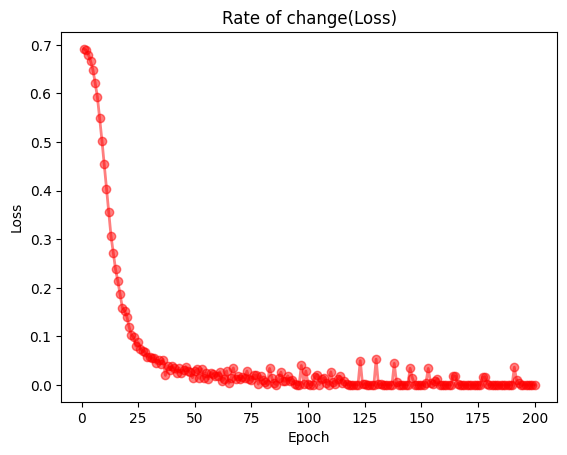

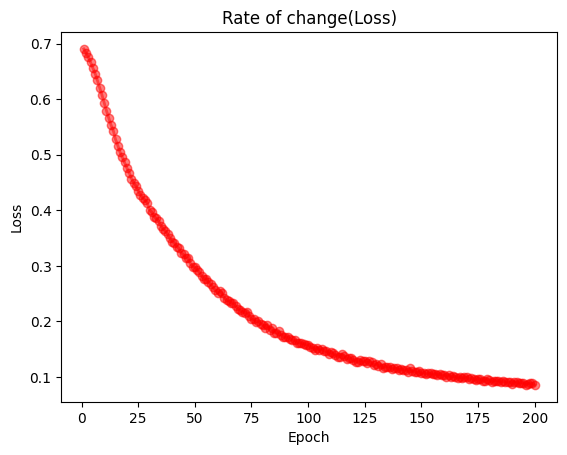

In [10]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import datetime

# train_epoch 함수 수정
def train_epoch(model, train_loader, criterion, optimizer, device, epoch, train_loss):
    model.train()
    running_loss = 0.0

    for batch_idx, (img1, img2, label) in enumerate(train_loader, 1):
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        
        optimizer.zero_grad()
        output = model(img1, img2)
        loss = criterion(output, label.view(-1, 1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    average_loss = running_loss / len(train_loader)
    train_loss.append(round(average_loss, 4))

    print(f'[+] {epoch+1} Epoch Training Loss: {average_loss:.4f}')
    return train_loss

def time_check(start):
    execute_time = time.time() - start
    times = str(datetime.timedelta(seconds = execute_time))
    short = times.split(".")[0]
    print(f"[+] 코드 실행 시간 : {short}")

def loss_change_visual(x, y):
    plt.plot(x, y, color = 'red', marker = 'o', alpha = 0.5, linewidth = 2)
    plt.title("Rate of change(Loss)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

start = time.time()

# 전역 변수로 train_loss 리스트를 정의
train_loss = []
fre_train_loss = []
loss_early_exit_number = 10
quit_flag = False
fre_quit_flag = False

# 모델, 손실 함수, 최적화 알고리즘 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)  # SiameseNetwork 정의 필요
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00006)

fre_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fre_model = SiameseNetwork().to(device)  # SiameseNetwork 정의 필요
fre_criterion = torch.nn.BCELoss()
fre_optimizer = optim.Adam(fre_model.parameters(), lr=0.00006)


epoch_list = []
fre_epoch_list = []

# 학습 실행
print(f"[+] 일반 Image 모델 학습 시작 ! ")
for epoch in range(200):
    if not quit_flag:
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device, epoch, train_loss)
        epoch_list.append(epoch+1)
        # 조기 종료 조건 확인
        if epoch >= loss_early_exit_number:
            if all(train_loss[-1] == loss for loss in train_loss[-loss_early_exit_number:]):
                print(f"[+] 일반 Image 모델 조기 종료: {epoch+1} 에포크에서 종료")
                quit_flag = True
    else:
        break

print(f"[+] Frequence 기반 학습 Image 모델 학습 시작 ! ")
for fre_epoch in range(200):
    if not fre_quit_flag:
        fre_train_loss = train_epoch(fre_model, fre_train_loader, fre_criterion, fre_optimizer, fre_device, fre_epoch, fre_train_loss)
        fre_epoch_list.append(fre_epoch+1)

        if fre_epoch >= loss_early_exit_number:
            if all(fre_train_loss[-1] == fre_loss for fre_loss in fre_train_loss[-loss_early_exit_number:]):
                print(f"[+] Frequence 기반 모델 조기 종료: {fre_epoch+1} 에포크에서 종료")
                fre_quit_flag = True
    else:
        break
        
time_check(start)
loss_change_visual(epoch_list, train_loss)
loss_change_visual(fre_epoch_list, fre_train_loss)

In [19]:
model_loss_list = []
fre_model_loss_list = []

for i in range(len(train_loss)):
    model_loss_list.append([epoch_list[i], train_loss[i]])

for i in range(len(fre_train_loss)):
    fre_model_loss_list.append([fre_epoch_list[i], fre_train_loss[i]])

In [20]:
df = pd.DataFrame(fre_model_loss_list, columns=['epoch', 'loss'])

In [21]:
df.to_csv('/home/cti/byeongyeol/siamese_network/model_loss_data/dual_siamese_network_fre_model_30000_loss.csv', sep = ',')

Accuracy on the test set: 83.1000%


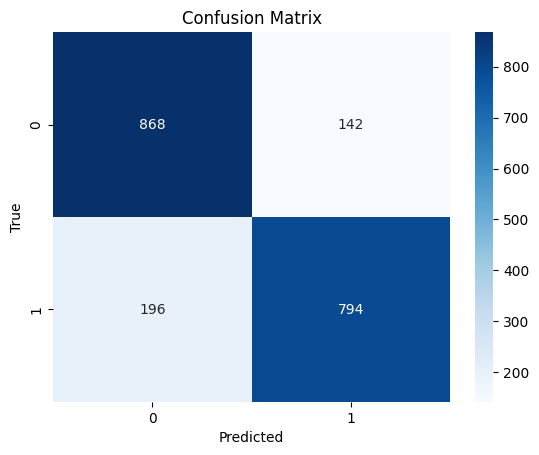

[+] Accuracy : 0.831
[+] Precision : 0.8482905982905983
[+] Recall : 0.802020202020202
[+] F1-Score : 0.8245067497403946
Accuracy on the test set: 82.4500%


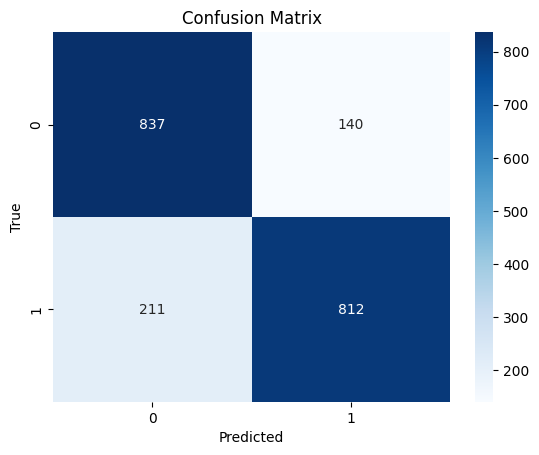

[+] Accuracy : 0.8245
[+] Precision : 0.8529411764705882
[+] Recall : 0.793743890518084
[+] F1-Score : 0.8222784810126582
Accuracy on the test set: 83.4000%


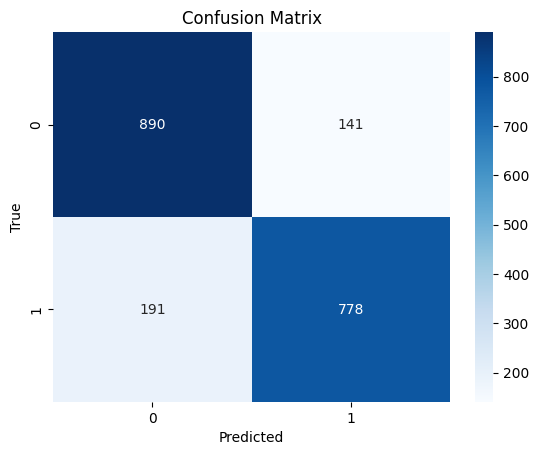

[+] Accuracy : 0.834
[+] Precision : 0.8465723612622416
[+] Recall : 0.8028895768833849
[+] F1-Score : 0.8241525423728814
Accuracy on the test set: 82.6500%


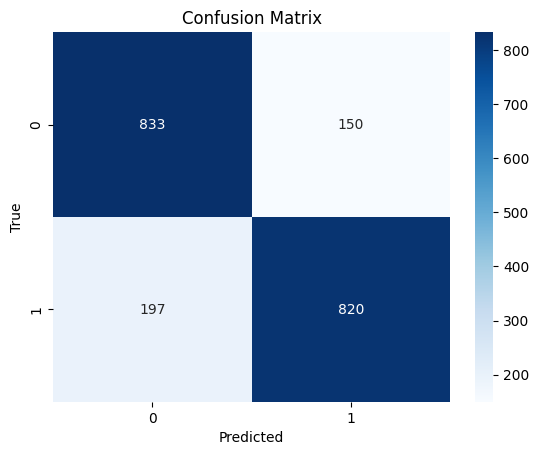

[+] Accuracy : 0.8265
[+] Precision : 0.845360824742268
[+] Recall : 0.8062930186823992
[+] F1-Score : 0.8253648716658278
Accuracy on the test set: 82.4500%


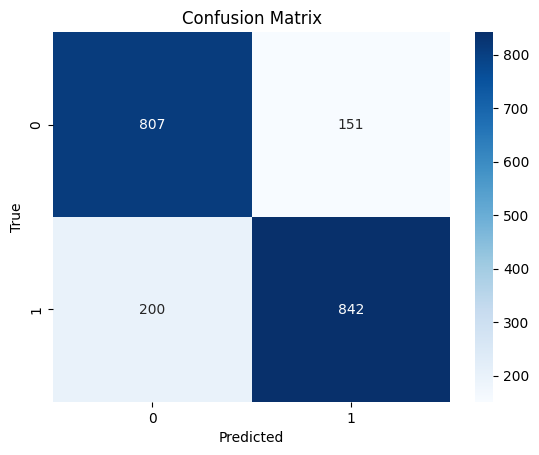

[+] Accuracy : 0.8245
[+] Precision : 0.8479355488418933
[+] Recall : 0.8080614203454894
[+] F1-Score : 0.8275184275184275
Accuracy on the test set: 81.1000%


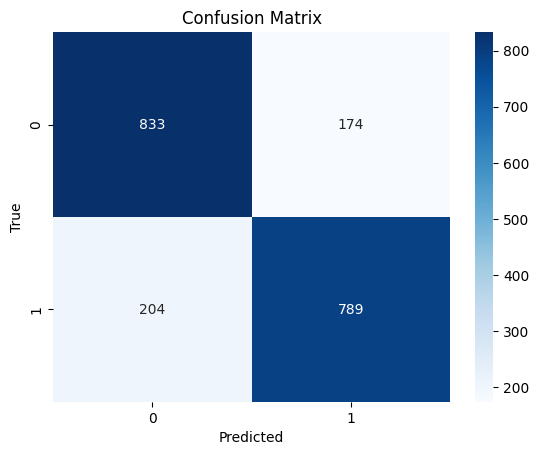

[+] Accuracy : 0.811
[+] Precision : 0.8193146417445483
[+] Recall : 0.7945619335347432
[+] F1-Score : 0.8067484662576687
Accuracy on the test set: 81.7500%


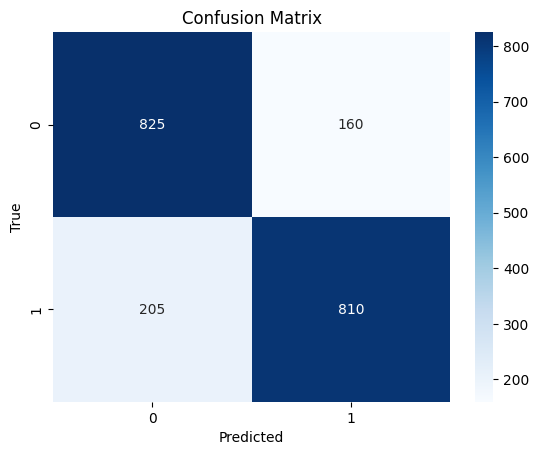

[+] Accuracy : 0.8175
[+] Precision : 0.8350515463917526
[+] Recall : 0.7980295566502463
[+] F1-Score : 0.8161209068010076
Accuracy on the test set: 81.4500%


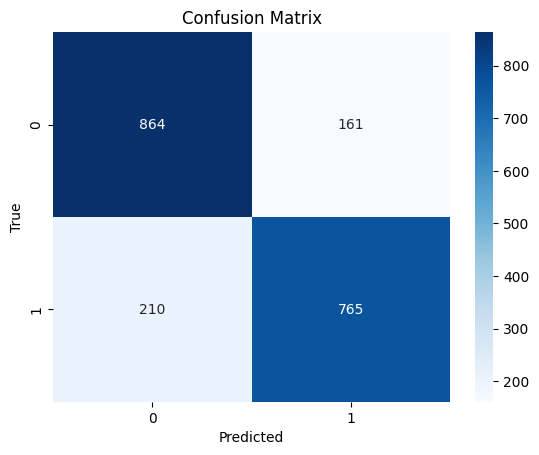

[+] Accuracy : 0.8145
[+] Precision : 0.826133909287257
[+] Recall : 0.7846153846153846
[+] F1-Score : 0.8048395581273015
Accuracy on the test set: 81.6000%


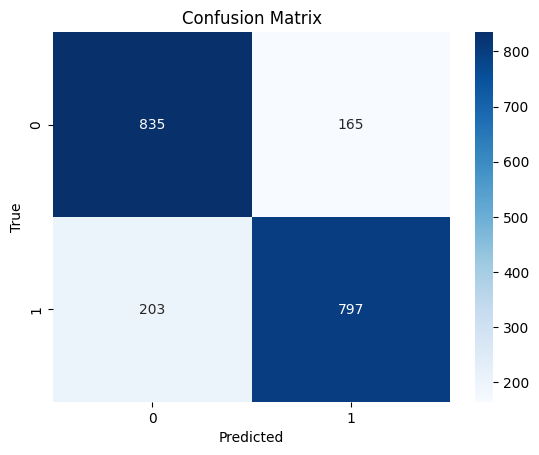

[+] Accuracy : 0.816
[+] Precision : 0.8284823284823285
[+] Recall : 0.797
[+] F1-Score : 0.8124362895005097
Accuracy on the test set: 81.7000%


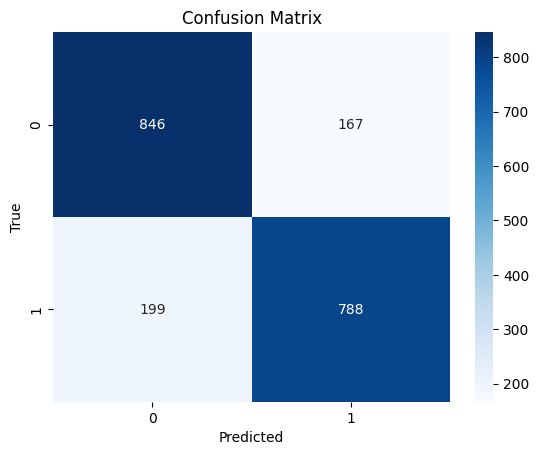

[+] Accuracy : 0.817
[+] Precision : 0.8251308900523561
[+] Recall : 0.7983789260385005
[+] F1-Score : 0.811534500514933
Accuracy on the test set: 82.5500%


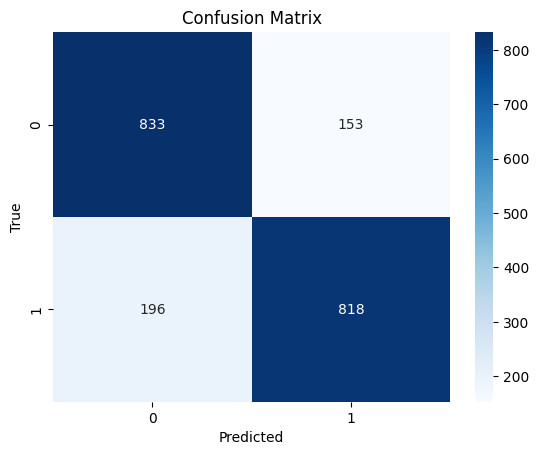

[+] Accuracy : 0.8255
[+] Precision : 0.8424304840370752
[+] Recall : 0.8067061143984221
[+] F1-Score : 0.8241813602015113
Accuracy on the test set: 82.8500%


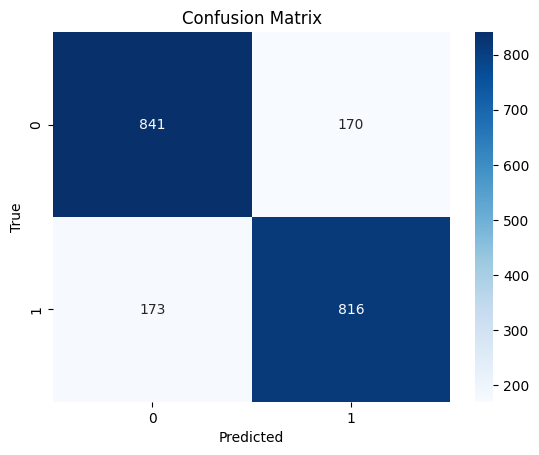

[+] Accuracy : 0.8285
[+] Precision : 0.8275862068965517
[+] Recall : 0.8250758341759353
[+] F1-Score : 0.8263291139240506
Accuracy on the test set: 82.1000%


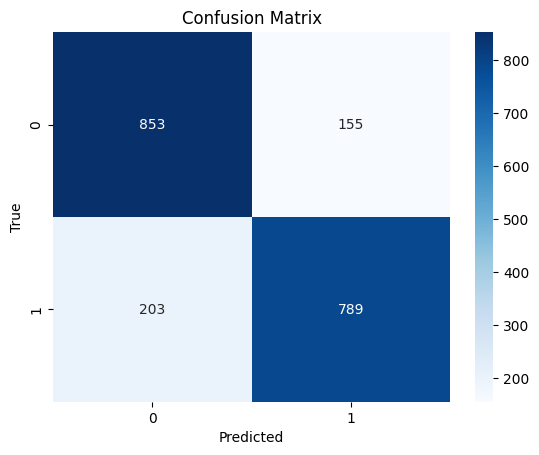

[+] Accuracy : 0.821
[+] Precision : 0.8358050847457628
[+] Recall : 0.7953629032258065
[+] F1-Score : 0.8150826446280992
Accuracy on the test set: 82.0000%


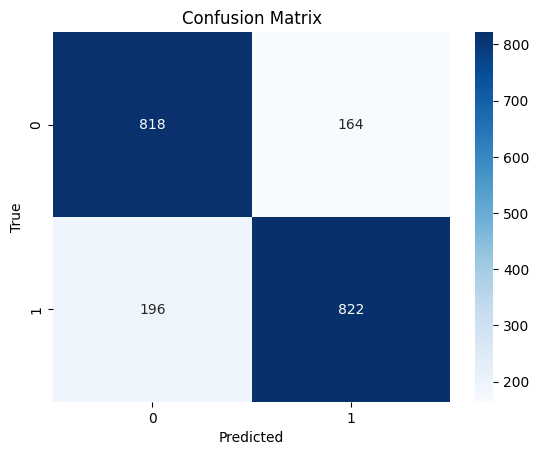

[+] Accuracy : 0.82
[+] Precision : 0.8336713995943205
[+] Recall : 0.8074656188605108
[+] F1-Score : 0.8203592814371258
Accuracy on the test set: 83.4500%


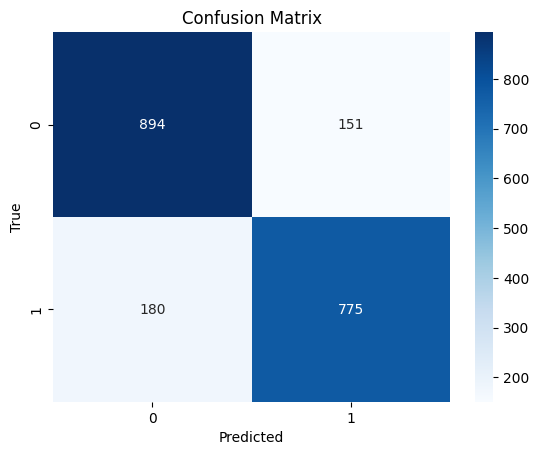

[+] Accuracy : 0.8345
[+] Precision : 0.8369330453563715
[+] Recall : 0.8115183246073299
[+] F1-Score : 0.8240297713981924
Accuracy on the test set: 82.4000%


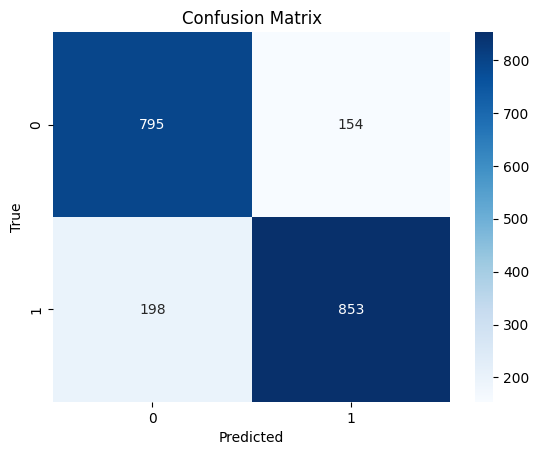

[+] Accuracy : 0.824
[+] Precision : 0.8470705064548163
[+] Recall : 0.8116079923882017
[+] F1-Score : 0.8289601554907677
Accuracy on the test set: 83.0000%


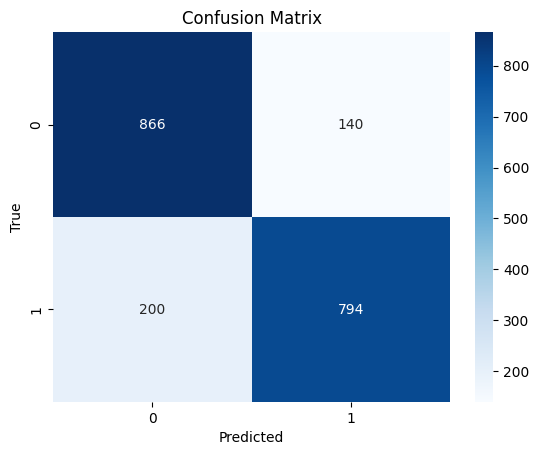

[+] Accuracy : 0.83
[+] Precision : 0.8501070663811563
[+] Recall : 0.7987927565392354
[+] F1-Score : 0.8236514522821576
Accuracy on the test set: 82.5000%


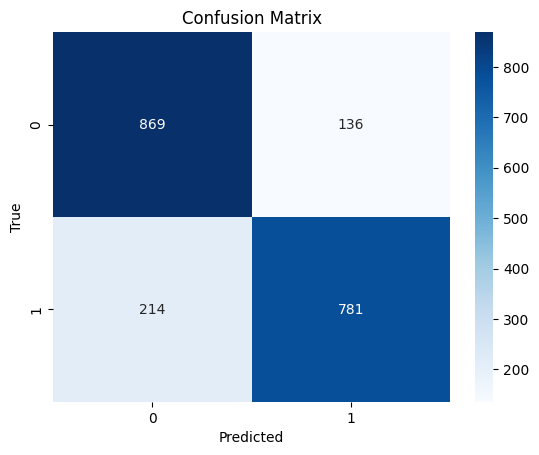

[+] Accuracy : 0.825
[+] Precision : 0.8516902944383861
[+] Recall : 0.7849246231155779
[+] F1-Score : 0.8169456066945606
Accuracy on the test set: 83.6500%


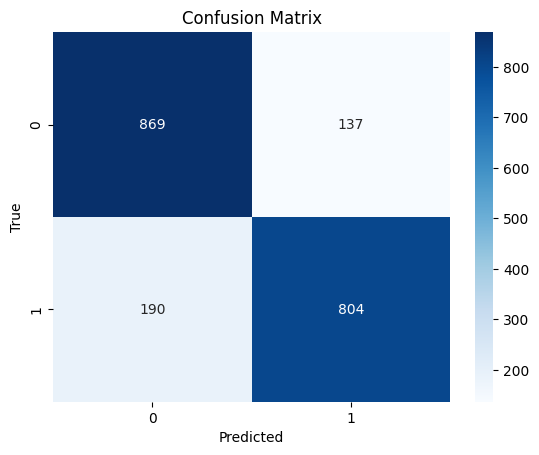

[+] Accuracy : 0.8365
[+] Precision : 0.8544102019128587
[+] Recall : 0.8088531187122736
[+] F1-Score : 0.8310077519379845
Accuracy on the test set: 82.4000%


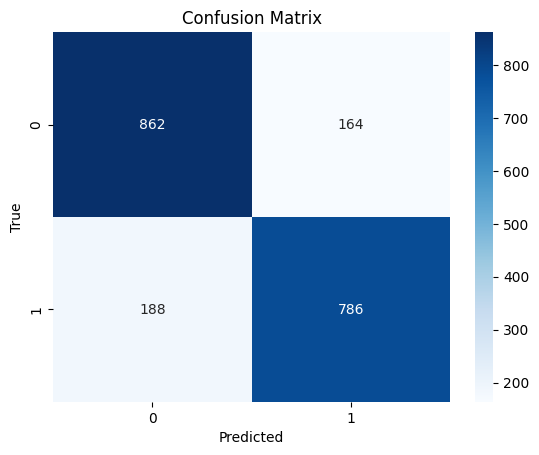

[+] Accuracy : 0.824
[+] Precision : 0.8273684210526315
[+] Recall : 0.8069815195071869
[+] F1-Score : 0.817047817047817


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


def evaluate_model(model, test_loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    base_model_weight = 0.0
    fre_model_weight = 1.0
    
    with torch.no_grad():  # 기울기 계산을 비활성화
        y_pred = []
        y_true = []
        for normal_img, abnormal_img, fre_normal_img, fre_abnormal_img, target_img, fre_target_img, label in test_loader:
            normal_img, abnormal_img, fre_normal_img, fre_abnormal_img, target_img, fre_target_img, label = normal_img.to(device), abnormal_img.to(device), fre_normal_img.to(device), fre_abnormal_img.to(device), target_img.to(device), fre_target_img.to(device), label.to(device)

            # 정상클래스 이미지와 타겟클래스 이미지 유사도 
            normal_target_outputs = model(normal_img, target_img).squeeze()
            abnormal_target_outputs = model(abnormal_img, target_img).squeeze()

            # 다른 모델
            fre_normal_target_outputs = fre_model(fre_normal_img, fre_target_img).squeeze()
            fre_abnormal_target_outputs = fre_model(fre_abnormal_img, fre_target_img).squeeze()

            # 가중치에 곱한 값
            result_normal_target_outputs = (base_model_weight * normal_target_outputs + fre_model_weight * fre_normal_target_outputs) / 2
            result_abnormal_target_outputs = (base_model_weight * abnormal_target_outputs + fre_model_weight * fre_abnormal_target_outputs) / 2
            # 이진 예측 값 결정

            # target_img가 정상일 경우 
            if label.item() == 1.0:
                predicted = 1.0 if result_normal_target_outputs > result_abnormal_target_outputs else 0.0
                
            elif label.item() == 0.0:
                  predicted = 0.0 if result_normal_target_outputs < result_abnormal_target_outputs else 1.0    
                
            
            y_pred.append(predicted)  # 예측값 추가
            y_true.append(label.item())  # 실제값 추가 (텐서에서 스칼라 값 추출)
            # print(y_true)
            total += 1
            
            if predicted == label.item():
                correct += 1

    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.4f}%')
    
    return np.array(y_true), np.array(y_pred)  # NumPy 배열로 변환하여 반환
    
def cf_matrix(y_true, y_pred, classes):
    
    cf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf_matrix, annot=True, fmt = 'd', cmap = 'Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def evaluation_check(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_score_test = f1_score(y_true, y_pred)
    print(f"[+] Accuracy : {accuracy}\n[+] Precision : {precision}\n[+] Recall : {recall}\n[+] F1-Score : {f1_score_test}")
classes = (0.0, 1.0)

# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 평가 실행
for i in range(20):
    y_true, y_pred = evaluate_model(model, test_loader, device)
    cf_matrix(y_true, y_pred, classes)
    evaluation_check(y_true, y_pred)


In [15]:
import pickle

with open('/home/cti/byeongyeol/siamese_network/model_pickle/dual_siamese_network_model_30000.pickle', 'wb') as f:
    pickle.dump(model, f)

with open('/home/cti/byeongyeol/siamese_network/model_pickle/dual_siamese_network_fre_model_30000.pickle', 'wb') as f:
    pickle.dump(fre_model, f)